<a href="https://colab.research.google.com/github/lilanpei/NMT/blob/master/NMT_Bi_GRU_%2B_Attention_%2B_pre_trained_Fasttext_word_embedding_%2B_k_Beam_search_%2B_BLEU_score_Microblog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tokenizing:

In [ ]:
# from nltk.parse import CoreNLPParser
# parser = CoreNLPParser('http://localhost:9001')
# with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
#     with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
#         for _ , line in enumerate(f):
#             cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [ ]:
# from nltk.parse import CoreNLPParser
# parser = CoreNLPParser('http://localhost:9001')
# with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
#     with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
#         for _ , line in enumerate(f):
#             cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [48]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [49]:
!/opt/bin/nvidia-smi

Thu Jun 18 07:22:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    71W / 149W |   4365MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [50]:
# For easy reset of notebook state.
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
tf.keras.backend.clear_session()

config_proto = tf.compat.v1.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.compat.v1.Session(config=config_proto)
tf.compat.v1.keras.backend.set_session(session)

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [53]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [54]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang, num_words):
    lang_tokenizer = T.Tokenizer(num_words=num_words,filters='', oov_token='<UNK>')
    lang_tokenizer.fit_on_texts(lang)
    lang_tokenizer.word_index = {e:i for e,i in lang_tokenizer.word_index.items() if i <= lang_tokenizer.num_words}
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

In [55]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None, num_words=80000):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang, num_words*2 if num_words else None)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang, num_words)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [56]:
path_to_file_zh = r'/content/drive/My Drive/NLP/NMT/Bi-Microblog_zh.tok'
path_to_file_en = r'/content/drive/My Drive/NLP/NMT/Bi-Microblog_en.tok'

# Try experimenting with the size of that dataset
#num_examples = 450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en)#, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [57]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 13756, 11113


In [ ]:
inps, targs  = create_dataset(path_to_file_zh, path_to_file_en)
tokens_zh = [[token for token in sents.split()] for sents in inps]
tokens_en = [[token for token in sents.split()] for sents in targs]

In [ ]:
from gensim.models import FastText
vector_size = 100
fast_model_zh = FastText(tokens_zh, size=vector_size, window=1, min_count=5, sg=1, iter=20, negative=10)
fast_model_en = FastText(tokens_en, size=vector_size, window=1, min_count=5, sg=1, iter=20, negative=10)

In [ ]:
import numpy as np

# Generate embedding vectors for <start> and <end> token
def initSpecialToken(vector_size, seed):
    np.random.seed(seed)
    return np.random.rand(vector_size)

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(fast_model, word2index, vector_size, num_tokens):
    embedding_matrix = np.zeros((num_tokens, vector_size))
    start_token_vec = initSpecialToken(vector_size, 0) #'<start>' 
    end_token_vec = initSpecialToken(vector_size, 1) # '<end>'
    unknown_token_vec = initSpecialToken(vector_size, 2) # '<end>'
    
    for word, idx in word2index.items():
        try:
          word_vec = fast_model.wv.word_vec(word)
        except KeyError:
          if word == '<start>':
            word_vec = start_token_vec
          if word == '<end>':  
            word_vec = end_token_vec
          if word == '<UNK>':
            word_vec = unknown_token_vec
          print('Can not find word_vec', word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(fast_model_zh, inp_lang.word_index, vector_size, num_encoder_tokens)
# Save input embedding vectors
np.save(r'/content/drive/My Drive/NLP/input_emb_matrix', input_emb_matrix)
# Creating output embedding vectors
output_emb_matrix = get_embedding_matrix(fast_model_en, targ_lang.word_index, vector_size, num_decoder_tokens)
# Save output embedding vectors
np.save(r'/content/drive/My Drive/NLP/output_emb_matrix', output_emb_matrix)

In [58]:
import numpy as np
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'/content/drive/My Drive/NLP/NMT/input_emb_matrix_Microblog.npy'), np.load(r'/content/drive/My Drive/NLP/NMT/output_emb_matrix_Microblog.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (13756, 300), (11113, 300)


In [59]:
import numpy as np

# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(trained_vector_path, word2index, vector_size, num_tokens):
    trained_word_vec = word2vec(trained_vector_path)
    print('number of trained word vector: {}:{}'.format(trained_vector_path, len(trained_word_vec)))

    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
import numpy as np

vector_size = 300
trained_vector_paths = (r'/content/drive/My Drive/NLP/cc.zh.300.vec', r'/content/drive/My Drive/NLP/cc.en.300.vec')

# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(trained_vector_paths[0], inp_lang.word_index, vector_size, num_encoder_tokens)
output_emb_matrix = get_embedding_matrix(trained_vector_paths[1], targ_lang.word_index, vector_size, num_decoder_tokens)
# Save output embedding vectors
np.save(r'/content/drive/My Drive/NLP/input_emb_matrix_education', input_emb_matrix)
np.save(r'/content/drive/My Drive/NLP/output_emb_matrix_education', output_emb_matrix)

In [ ]:
import numpy as np
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'/content/drive/My Drive/NLP/input_emb_matrix.npy'), np.load(r'/content/drive/My Drive/NLP/output_emb_matrix.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

In [60]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 4000, 1000


In [61]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
#max_length_inp = max_length_targ = 30
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 85, 81


In [62]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size):
    while True:
        for i in range(0, len(input_tensor), batch_size):
            encoder_input_batch = input_tensor[i:i + batch_size]
            encoder_input_batch = S.pad_sequences(encoder_input_batch,padding='post', maxlen = max_length_inp, truncating='post')
            decoder_input_batch = target_tensor[i:i + batch_size]
            decoder_input_batch = S.pad_sequences([s[:-1] for s in decoder_input_batch],padding='post', maxlen = max_length_targ, truncating='post')
            decoder_target_batch = target_tensor[i:i + batch_size]
            decoder_target_batch = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in decoder_target_batch],padding='post', maxlen = max_length_targ, truncating='post')])
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [63]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [64]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

batch_size = 32
latent_dim = 300
# Set up the encoder
encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
print(encoder_inputs.shape, enc_emb.shape)
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

(32, 85) (32, 85, 300)


In [65]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
print(decoder_inputs.shape, dec_emb.shape)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder GRU output
print(decoder_outputs.shape,attn_out.shape)
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# Dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
decoder_outputs = dense_time(decoder_concat_input)

(32, 81) (32, 81, 300)
(32, 81, 600) (32, 81, 600)


In [66]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 85)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (32, 85, 300)        4126800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 81)]           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(32, 85, 600), (32, 1083600     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


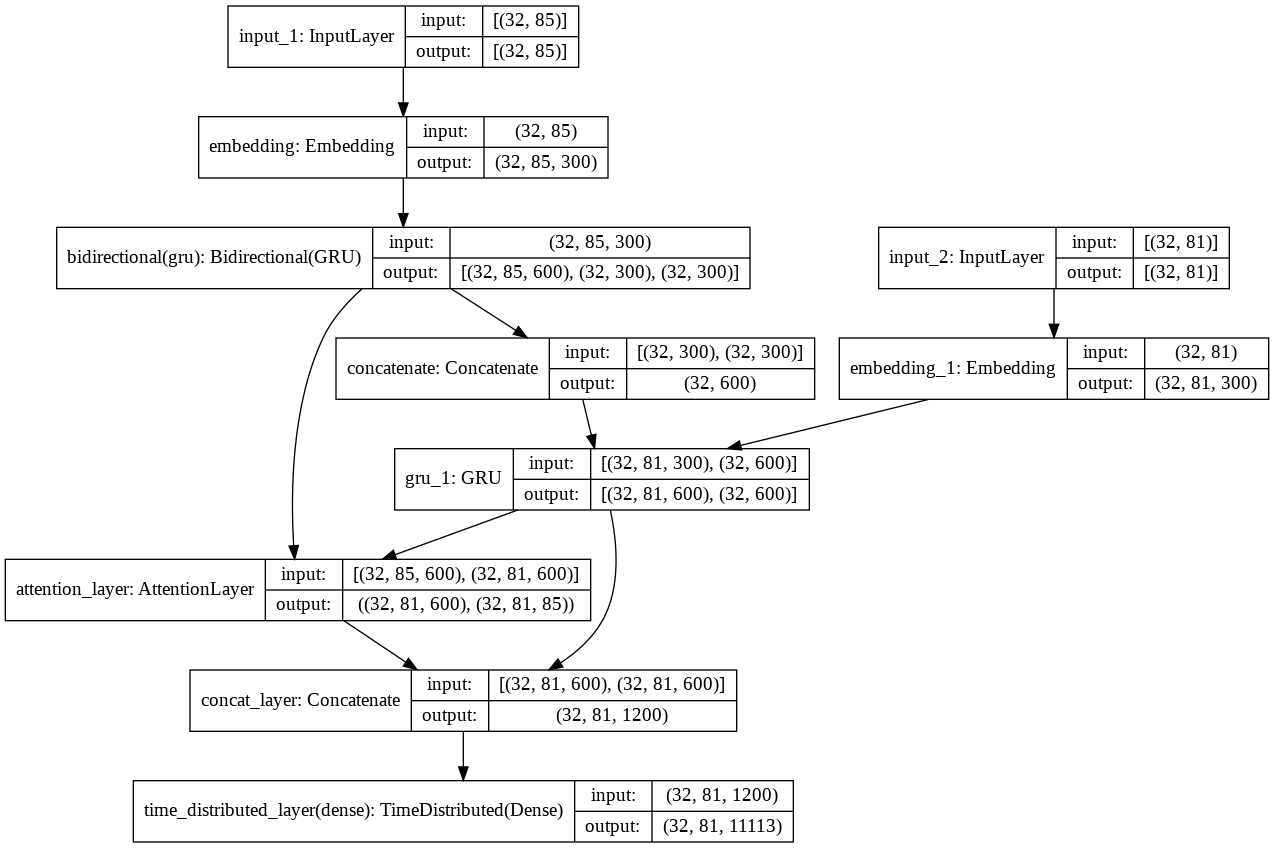

In [67]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [68]:
# Start training
epochs = 50
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/60
125/125 [==============================] - 100s 799ms/step - loss: 2.1081 - acc: 0.7349 - val_loss: 1.8027 - val_acc: 0.7480
Epoch 2/60
125/125 [==============================] - 98s 788ms/step - loss: 1.6761 - acc: 0.7550 - val_loss: 1.7148 - val_acc: 0.7557
Epoch 3/60
125/125 [==============================] - 99s 789ms/step - loss: 1.5709 - acc: 0.7610 - val_loss: 1.6849 - val_acc: 0.7607
Epoch 4/60
125/125 [==============================] - 99s 792ms/step - loss: 1.4766 - acc: 0.7654 - val_loss: 1.6540 - val_acc: 0.7639
Epoch 5/60
125/125 [==============================] - 99s 791ms/step - loss: 1.3916 - acc: 0.7685 - val_loss: 1.6382 - val_acc: 0.7657
Epoch 6/60
125/125 [==============================] - 99s 794ms/step - loss: 1.3117 - acc: 0.7714 - val_loss: 1.6423 - val_acc: 0.7672
Epoch 7/60
125/125 [==============================] - 100s 796ms/step - loss: 1.2336 - acc: 0.7755 - val_loss: 1.6533 - val_acc: 0.7670
Epoch 8/60
125/125 [==============================] -

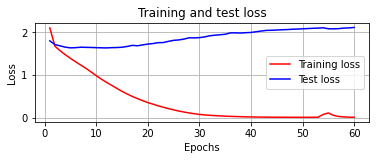

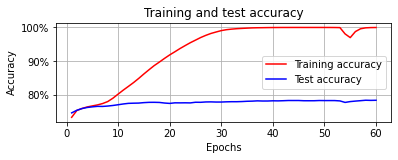

In [69]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [70]:
# Inference model
batch_size = 1

# Encoder (Inference) model
encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
# Encode the input sequence to get the "Context vectors"
encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])

# Decoder (Inference) model
decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
# Get the embeddings of the decoder sequence
dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
# Final decoder model
decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],
                        outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

In [71]:
# Encoder model summary
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay [(1, 85)]                 0         
_________________________________________________________________
embedding (Embedding)        multiple                  4126800   
_________________________________________________________________
bidirectional (Bidirectional multiple                  1083600   
Total params: 5,210,400
Trainable params: 1,083,600
Non-trainable params: 4,126,800
_________________________________________________________________


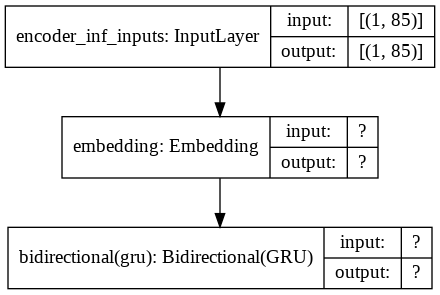

In [72]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [73]:
# Decoder model summary
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_word_inputs (InputLayer [(1, 1)]             0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             3333900     decoder_word_inputs[0][0]        
__________________________________________________________________________________________________
decoder_init (InputLayer)       [(1, 600)]           0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     multiple             1623600     embedding_1[1][0]                
                                                                 decoder_init[0][0]         

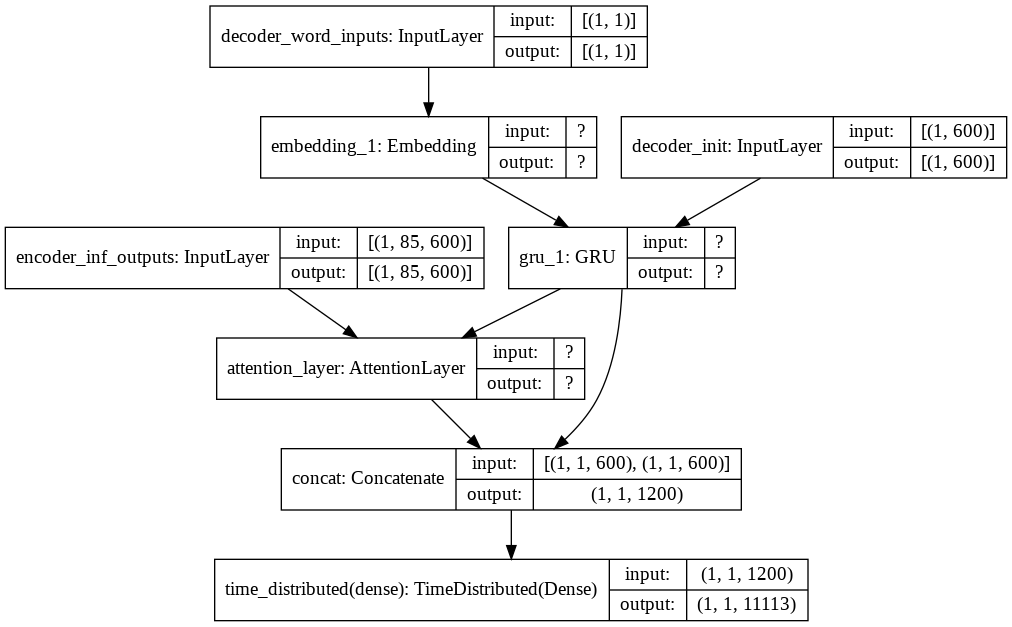

In [74]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [75]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

In [76]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [77]:
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /content

--2020-06-18 09:02:23--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  26.1MB/s    in 0.4s    

2020-06-18 09:02:23 (26.1 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      
mv: 'SimHei.ttf' and '/content/SimHei.ttf' are the same file


In [78]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.font_manager as fm
path = '//content/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=10)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())],fontproperties=fontprop)
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=24)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))

In [86]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

Input Source sentence: 我 希望 你 幸福 ， 因为 那 是 我 最大 的 心愿 。 我 又 怕 你 幸福 ， 因为 那样 你 就 会 忘 了 我 。
Actual   Target  Translation: i wish you be happy , because it is my biggest wish. i m also afraid you are happy , because then you will forget me .
Predicted Target Translation: i wish you be happy , because it is my biggest wish. i m also afraid you are happy , because then you will forget me .


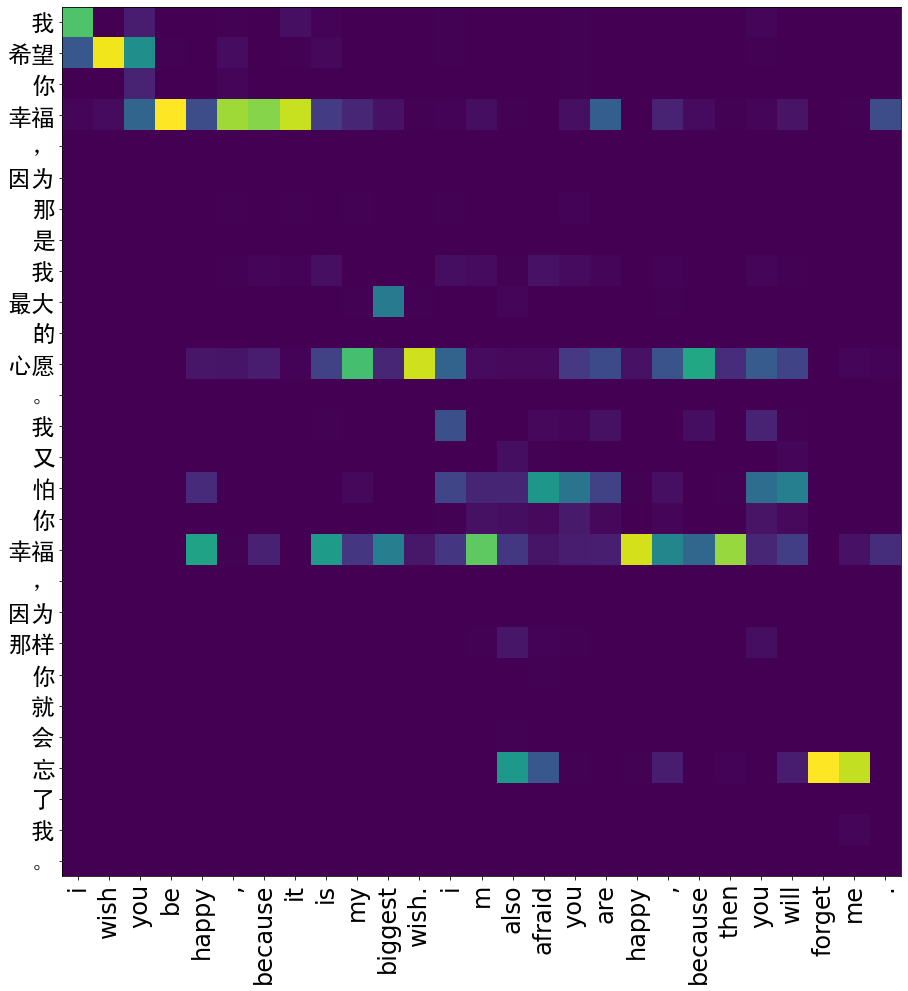

In [92]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
candidates = decode_sequence_with_k_beam_search(input_seq, 3)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual   Target  Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [81]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['accounting', 'fraud', 'allegations', 'that', 'have', 'dogged', 'various', 'companies', 'in', 'the', 'region', ',', 'whether', 'public', 'or', 'private']
Reference - Actual Target Translation: [['accounting', 'fraud', 'allegations', 'that', 'have', 'dogged', 'various', 'companies', 'in', 'the', 'region', ',', 'whether', 'public', 'or', 'private']]
Bleu score: 1.0


In [82]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 4000

Input Source sentence: 亚洲 不少 企业 包括 上市 企业 和 私有 企业 受到 会计 欺诈 指控 的 困扰
Actual Target Translation: accounting fraud allegations that have dogged various companies in the region , whether public or private
Predicted Target Translation: accounting fraud allegations that have dogged various companies in the region , whether public or private
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 4000

Input Source sentence: 与其 等到 别人 来 爱 你 ， 不如 自己 学着 努力 多 爱 自己 一些 。
Actual Target Translation: it s better to try hard to love yourself more than to wait someone to love you
Predicted Target Translation: it s better to try hard to love yourself more than to wait someone to love you
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 4000

Input

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。
-------------------------------------------------------------------------------------------------------------------------
Sample: 856 in total number of 4000

Input Source sentence: 我 不 完美 ， 我 会 犯错 ， 也 会 伤害 到 别人 。 但当 我 说 对不起 的 时候 ， 我 是 真心 的 。
Actual Target Translation: i m not perfect , i make mistakes , i hurt people. but when i say sorry , i mean it .
Predicted Target Translation: i m not perfect , i make mistakes , i hurt people. but when i say sorry , i mean it .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 857 in total number of 4000

Input Source sentence: 幸亏 我 逗留 上海 的 最后 一 天 ， 当 我 回到 新加坡 前 2012年 5月 18日 ， 上海 的 空气 变成 晴朗 ， 让 我 看到 这么 美妙 的 景色
Actual Target Translation: on my last day in shanghai before i returned to singapore 18 may 2012 the skies cleared up and i had this wonderful view of the city
Predicted Target Translation: on my last day in shanghai be

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 1570 in total number of 4000

Input Source sentence: 生命 中 有 很多 事情 足以 把 你 打倒 ， 但 真正 能 把 你 打倒 的 是 你 的 心态 。
Actual Target Translation: life always has many things to bring you down.but , what can really bring you down is when you don t manage your attitude .
Predicted Target Translation: life is a life in life is to make you find that you have his past , but what to change .
Bleu score: 0.677555463737908
-------------------------------------------------------------------------------------------------------------------------
Sample: 1571 in total number of 4000

Input Source sentence: 帕克 ， 我 原以为 你 只是 忽视 我 ， 可 现在 我 知道 了 ， 你 就是 在 针对 我 。
Actual Target Translation: used to think it was benign neglect , but now i see that you re intentionally screwing me .
Predicted Target Translation: used to think it was benign neglect , but now i see that you re intentionally screwing me .
Bleu score: 1.0
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。

Input Source sentence: 进一步 改善 生活 的 建议 养 一 只 狗 。 如果 你 爱 它 ， 它 会 无 条件 的 爱 你 。 对 我们 来说 ， cooper 就 是 这样 。 而 那些 你 爱的 人 ， 却 未必 如此
Actual Target Translation: further life improvement advice get a dog. if you love a dog they will love you back unconditionally . that s true of cooper for us. it s hard to say that about the people you love .
Predicted Target Translation: further life improvement advice get a dog. if you love a dog they will love you back unconditionally . that s true of cooper for us. it s hard to say that about the people you love .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 3287 in total number of 4000

Input Source sentence: 我的 胸部 有 猛烈 的 敲击 感 ， 好像 我 的 心脏 要 蹦出 来 一样
Actual Target Translation: a strong banging in my chest as if my heart was going to come out .
Predicted Target Translation: a strong banging in my chest as if my heart was going to come

In [93]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

Input Source sentence: 只有 每天 再度 战胜 生活 并 夺取 自由 的 人 ， 才 配 享受 生活 的 自由 。
Actual Target Translation: none is of freedom or of life deserving unless he daily conquers it anew .
Predicted Target Translation: none is of freedom or of life deserving unless he daily conquers it anew. erasmus


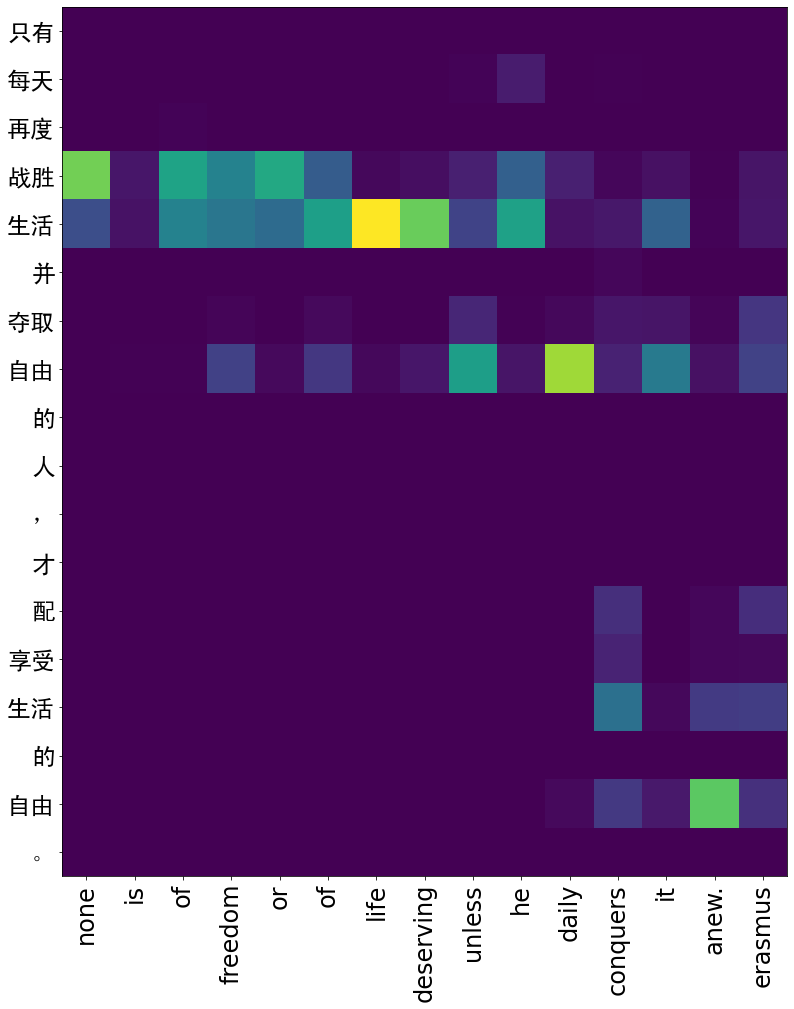

In [111]:
(input_seq, actual_output), _ = next(test_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [85]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 1000

Input Source sentence: 失败 的 次数 越 多 ， 成功 的 机会 亦 越 近 。 成功 往往 是 最后 一 分钟 来 的 客人 。
Actual Target Translation: the more failures , the more chances for success. success is usually the last minute visitor .
Predicted Target Translation: ricky martin isn t meant for being a mistake of the 1980 s experience and the labor done .
Bleu score: 0.6773709971213142
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 1000

Input Source sentence: 日出 之美 ， 无需 言语 来 描述 。
Actual Target Translation: you don t need somebody to interpret for you what a beautiful sunrise it is .
Predicted Target Translation: the more good man of the candle was tryna the sky was way .
Bleu score: 0.44815260192961937
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 1000

Input Source sentence: 让 读者 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 5 in total number of 1000

Input Source sentence: 可能 是 我 的 性格 过于 消极 吧 ， 只要 是 那些 忧伤 而 凄美 的 ， 我 都 喜欢 。
Actual Target Translation: may be my personality too negative , as long as it is sad and poignant , i like .
Predicted Target Translation: but , my , i am sad , because it is my weakness , and no one thing , go are my own mind .
Bleu score: 0.4161791450287817
-------------------------------------------------------------------------------------------------------------------------
Sample: 6 in total number of 1000

Input Source sentence: 这个 世界 上 最 残忍 的 一 句 话 ， 不 是 对不起 ， 也 不 是 我 恨 你 ， 而是 ， 我们 再 也 回 不 去 。
Actual Target Translation: the most merciless word in the world is not sorry , nor i hate you . instead , we can never go back again .
Predicted Target Translation: the world most really thing is before can not you , but it s even you can not expect it but not because you re not .
Bleu score: 0.33649324423301513
----------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。

Input Source sentence: 昨日 若 不 弃 ， 明日 多烦忧 。
Actual Target Translation: you can t have a better tomorrow if you don t stop thinking about yesterday .
Predicted Target Translation: so long as the future s day to see the future for it .
Bleu score: 0.44815260192961937
-------------------------------------------------------------------------------------------------------------------------
Sample: 287 in total number of 1000

Input Source sentence: 如果 结局 不 是 我 想 要的 ， 那么 我 宁愿 不 去 参与 这个 过程 。 我 有 我 的 骄傲 ， 凭什么 为了 你 去 卑微 自己 ！
Actual Target Translation: if the outcome is not what i want , then i would prefer not to participate in this process. i have my pride , what for you to humble yourself !
Predicted Target Translation: if is not so i do not be enough one or i didn t care you .
Bleu score: 0.17578345846522653
-------------------------------------------------------------------------------------------------------------------------
Sample: 288 in total number of 1000



In [114]:
path_to_file_zh = r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Testing-Data_zh.tok'
path_to_file_en = r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Testing-Data_en.tok'

# Try experimenting with the size of that dataset
#num_examples = 450000
input_tensor_ts, target_tensor_ts = create_dataset(path_to_file_zh, path_to_file_en)
input_tensor_ts, target_tensor_ts = inp_lang.texts_to_sequences(input_tensor_ts[4934:]), targ_lang.texts_to_sequences(target_tensor_ts[4934:])
# Number of Training/Testing samples
tr_samples = len(input_tensor)
ts_samples = len(input_tensor_ts)
print('Number of samples for Training/Testing: {}, {}'.format(tr_samples, ts_samples))

Number of samples for Training/Testing: 5000, 66


In [131]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 85)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             4126800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 81)]           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   multiple             1083600     embedding[0][0]                  
______________________________________________________________________________________________

In [133]:
# Start training
batch_size = 32
epochs = 50
history = model.fit_generator(generator = generate_batch(input_tensor, target_tensor, batch_size = batch_size),
                    steps_per_epoch = tr_samples//batch_size,
                    epochs=epochs)#,
                    # validation_data = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = batch_size),
                    # validation_steps = ts_samples//batch_size)

Epoch 1/50
156/156 [==============================] - 109s 700ms/step - loss: 0.1310 - acc: 0.9918
Epoch 2/50


InvalidArgumentError: ignored

In [134]:
# Make predictions on the Test dataset
ts_gen = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = 1)

Input Source sentence: 没有 人 可以 和 生活 讨价 还价 ， 所以 只要 活着 ， 就 一定 要 努力 。
Actual Target Translation: no one can bargain with life. you must endeavor as long as you are alive .
Predicted Target Translation: no one can bargain with life. you must endeavor as long as you are alive .


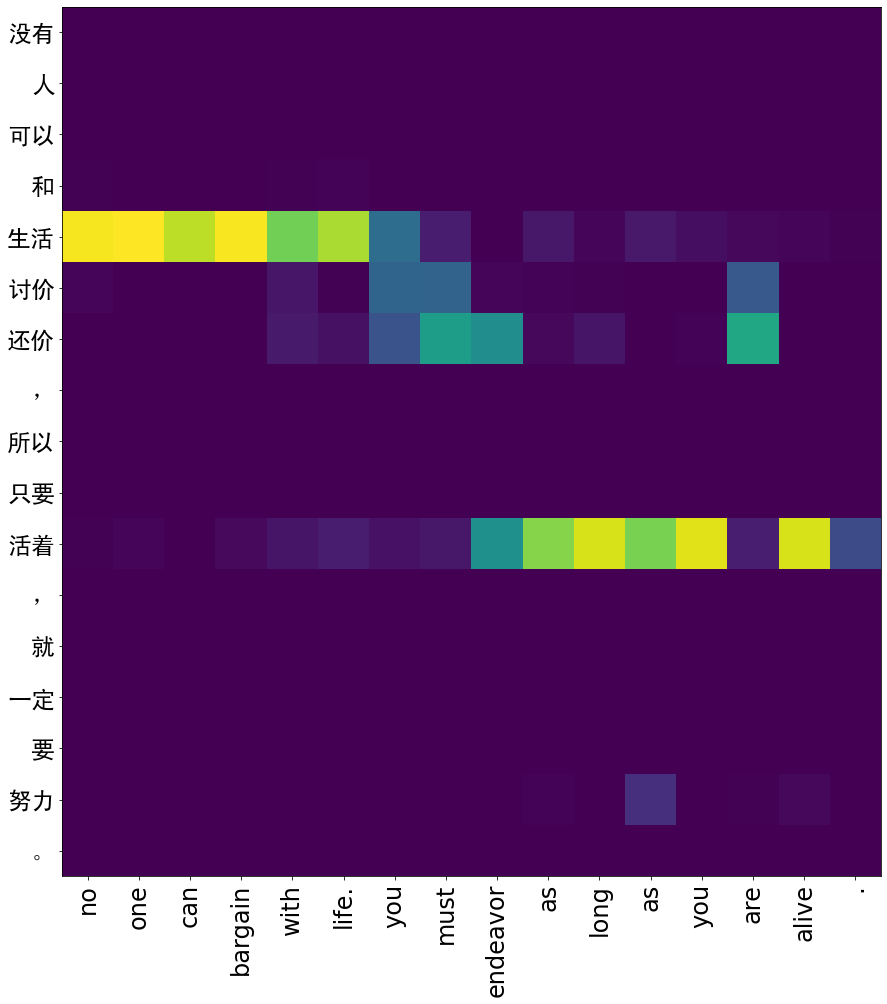

In [145]:
(input_seq, actual_output), _ = next(ts_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [125]:
ts_gen = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = 1)
N_samples = ts_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(ts_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 66

Input Source sentence: <UNK> <UNK> 的 时候 ， 总 会 有 人 把 房间 的 <UNK> 悄悄 地 关上 。
Actual Target Translation: when suddenly from the cool breeze , there is always someone put the room quietly shut the <UNK> and windows .
Predicted Target Translation: the big thing in the world to save his own clamor of the royal .
Bleu score: 0.48169749774377824
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 66

Input Source sentence: 些 似 小 非 小 ， 看轻 非 轻 的 点点滴滴 却 都 源于 一 个 不 变 的 <UNK> ， 那 就 是 亲情 。
Actual Target Translation: these seem small non small , underestimate the importance of non light none <UNK> from a constant mind , it is affection .
Predicted Target Translation: a recent piece of your is to be a person , used to people , but is a kind of soft warmth that is nothing to be found .
Bleu score: 0.6744322250214191
-----------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 5 in total number of 66

Input Source sentence: 有时候 ， 我们 做 过 的 最 艰难 的 选择 ， 最终 成 了 我们 为 自己 做 过 的 最 棒 的 事 。
Actual Target Translation: sometimes the hardest choices we make end up being the best thing we could have ever done for ourselves .
Predicted Target Translation: sometimes the most things we cannot in the most of the things we re going to be a great show .
Bleu score: 0.34572078464194106
-------------------------------------------------------------------------------------------------------------------------
Sample: 6 in total number of 66

Input Source sentence: 假如 你 的 <UNK> 是 100年 ， 那 我 希望 自己 <UNK> 100 岁 的 前 一 天 ， 因为 那样 我 的 生命 中 每天 都 有 你 。
Actual Target Translation: if you live to be 100 years old , i hope i live to be 100 <UNK> 1 day , so i never have to live without you .
Predicted Target Translation: if you re the one day my life , i d rather be the end of my life .
Bleu score: 0.26573541615300783
------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 9 in total number of 66

Input Source sentence: 就算 只有 自己 的 影子 陪伴 ， 也 不 要 忘记 对 自己 微笑 。
Actual Target Translation: even though you only have the shadow of yourself with you , don t forget to smile to yourself .
Predicted Target Translation: even when someone person person , someone will not forget to smile again .
Bleu score: 0.17736010878085468
-------------------------------------------------------------------------------------------------------------------------
Sample: 10 in total number of 66

Input Source sentence: 没有 人 可以 和 生活 讨价 还价 ， 所以 只要 活着 ， 就 一定 要 努力 。
Actual Target Translation: no one can bargain with life. you must endeavor as long as you are alive .
Predicted Target Translation: no one can bargain with life. you must endeavor as long as you are alive .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 11 in total number of 66

Input Source sentence: 不要 后悔 。 如果 好 ， 那 很 棒 